### 모듈 가져오기

In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/Othercomputers/내 노트북/07_PJT_final_01/01_clothes_classification

/content/drive/Othercomputers/내 노트북/07_PJT_final_01/01_clothes_classification


In [4]:
img_size = 224
channel=3

In [5]:
train_datagen = ImageDataGenerator( 
        rescale=1./255,         # 픽셀 값을 0~1 범위로 변환
        # rotation_range=40,      # 40도까지 회전
        # width_shift_range=0.2,  # 20%까지 좌우 이동
        # height_shift_range=0.2, # 20%까지 상하 이동
        # shear_range=0.2,        # 20%까지 기울임
        # zoom_range=0.2,         # 20%까지 확대
        # horizontal_flip=True,   # 좌우 뒤집기
    )
train_generator = train_datagen.flow_from_directory(
    './dataset/Train',
    batch_size=200,      
    class_mode='categorical', 
    target_size=(img_size, img_size)) 
valid_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
valid_generator = valid_datagen.flow_from_directory(
    './dataset/Validation',
    batch_size=80,      
    class_mode='categorical', 
    target_size=(img_size, img_size))
test_datagen = ImageDataGenerator(rescale=1./255) # 스케일링만 진행
test_generator = test_datagen.flow_from_directory(
    './dataset/data/test',
    batch_size=10,      
    class_mode='categorical', 
    target_size=(img_size, img_size),
    shuffle=False)

Found 32426 images belonging to 4 classes.
Found 7894 images belonging to 4 classes.
Found 10 images belonging to 4 classes.


In [6]:
print('train_generator class : ', train_generator.class_indices)
print('valid_generator class : ', valid_generator.class_indices)
print('test_generator class : ', test_generator.class_indices)

train_generator class :  {'bottoms': 0, 'one-piece': 1, 'outerwear': 2, 'tops': 3}
valid_generator class :  {'bottoms': 0, 'one-piece': 1, 'outerwear': 2, 'tops': 3}
test_generator class :  {'bottoms': 0, 'one-piece': 1, 'outerwear': 2, 'tops': 3}


### 모델 학습하기 - MobileNetV2
- imagenet 전이학습
- 은닉층
   * Flatten(input_shape=(112,112))
   * Dense(224, activation='relu')
   * Dropout(0.2)
- 출력층
   * Dense(10, activation='softmax')
- compile
   * learning rate : 0.0002

In [7]:
# 파라미터 설정
classes = len(train_generator.class_indices)
epochs = 200
batch_size = 96

In [8]:
MobileNet = tf.keras.applications.MobileNetV2(weights='imagenet',
                                              include_top=False, 
                                              input_shape=(img_size, img_size, 3))
MobileNet.trainable = False # 학습으로 기존 가중치 갱신을 하지 않도록 지정

9420800/9406464 [==============================] - 0s 0us/step


In [9]:
model = Sequential()
model.add(MobileNet)
model.add(Flatten(input_shape=(112,112)))
model.add(Dense(224, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 224)               14049504  
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 900       
                                                                 
Total params: 16,308,388
Trainable params: 14,050,404
Non-trainable params: 2,257,984
____________________________________

In [10]:
# 모델 환경설정
model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [11]:
model_name = './model/MobileNetV2_02_{epoch:02d}-{val_loss:.4f}.hdf5'
checkpointer = ModelCheckpoint(filepath=model_name, monitor='val_loss',save_best_only=True) # 성능이 개선될떄만 저장하도록
earlystopping = EarlyStopping(monitor='val_loss', patience=5) # 5번동안 성능개선이 없으면 학습 조기종료

In [12]:
history = model.fit(train_generator,
                    validation_data=valid_generator, 
                    callbacks = [[earlystopping, checkpointer]]) 

163/163 [==============================] - 20650s 127s/step - loss: 2.4194 - accuracy: 0.7596 - val_loss: 0.2638 - val_accuracy: 0.8974


In [13]:
max(history.history['accuracy'])

0.7596373558044434

In [14]:
# 모델 저장
accuracy = round(max(history.history['accuracy'])*100,0)
model.save(f'./model/MobileNetV2_01_model_acc{accuracy}.h5') # 최종 모델 저장

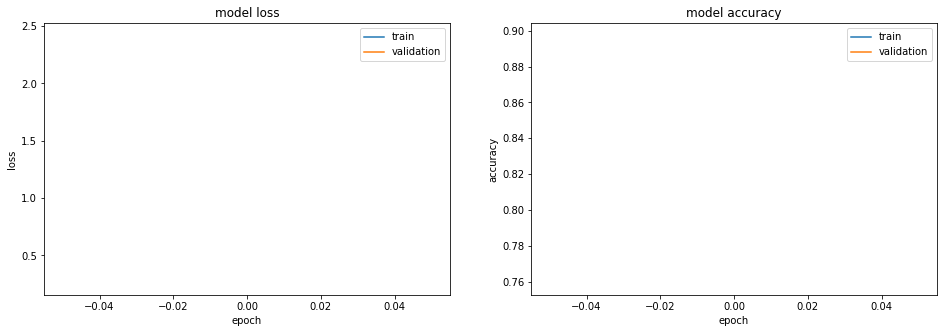

In [15]:
plt.figure(figsize=(16,5))

# 만들어진 모델에 대해 train dataset과 validation dataset의 loss 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

# 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy 를 그래프로 표현해 봅니다.
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc=0)

In [16]:
model.evaluate(test_generator)

1/1 [==============================] - 0s 426ms/step - loss: 0.8691 - accuracy: 0.7000


[0.869094967842102, 0.699999988079071]

In [ ]:
train_generator.class_indices

{'bottoms': 0, 'one-piece': 1, 'outerwear': 2, 'tops': 3}

In [17]:
Y_pred = model.predict(test_generator)
classes = test_generator.classes[test_generator.index_array]
y_pred = np.argmax(Y_pred, axis=1) 

# class_names = ['bottoms', 'one-piece', 'outerwear', 'tops'] 
result_dict = dict(map(reversed, test_generator.class_indices.items()))
class_names = list(result_dict.values())

print('-- Confusion Matrix --')
print(confusion_matrix(classes, y_pred))

print('-- Classification Report --')
print(classification_report(classes, y_pred, target_names=class_names))


-- Confusion Matrix --
[[4 0 0]
 [0 3 3]
 [0 0 0]]
-- Classification Report --


ValueError: ignored

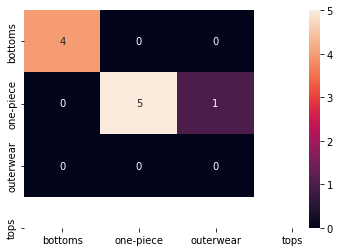

In [ ]:
sns.heatmap(confusion_matrix(classes, y_pred), annot=True, fmt='d',
            xticklabels=['bottoms', 'one-piece', 'outerwear', 'tops'] ,
            yticklabels=['bottoms', 'one-piece', 'outerwear', 'tops'] )

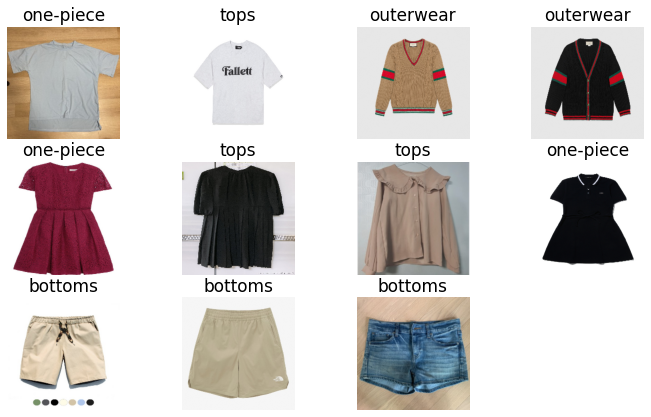

In [19]:
# 직접 찍은 음료 이미지로 예측 결과 확인

class_dict = {0:'bottoms', 1:'one-piece', 2:'outerwear', 3:'tops'}

fig = plt.figure(figsize=(12,12))
i=0
for img in glob.glob('./dataset/test/*.jpg'):
    ax = plt.subplot(4,4,i+1) 
    test_img = cv2.imread(img)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
    test_img = cv2.resize(test_img,(224,224))/255.0
    test_img_input = test_img.reshape((1,)+test_img.shape)
    pred = model.predict(test_img_input)
    pred_class = class_dict[np.argmax(pred, axis=1)[0]]
    ax.imshow(test_img)
    ax.axis('off')
    ax.set_title(f'{pred_class}',fontsize=17)
    i += 1
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.7, wspace=0.2, hspace=0.2)
plt.show()